# Descripción
Un avión vuela con velocidad 
$V$
 a 
$Ha$
 metros del suelo en dirección a un cañón como se muestra en la figura.

El cañón tiene forma de trapecio isósceles invertido, de una altura 
$H
c$
, largo 
$L$
 y ángulo 
$α$
 con respecto al horizonte.

Cuando se encuentra a una distancia 
$d$
 del borde del cañón, el avión suelta una bomba.

![Imagen](im2.png)



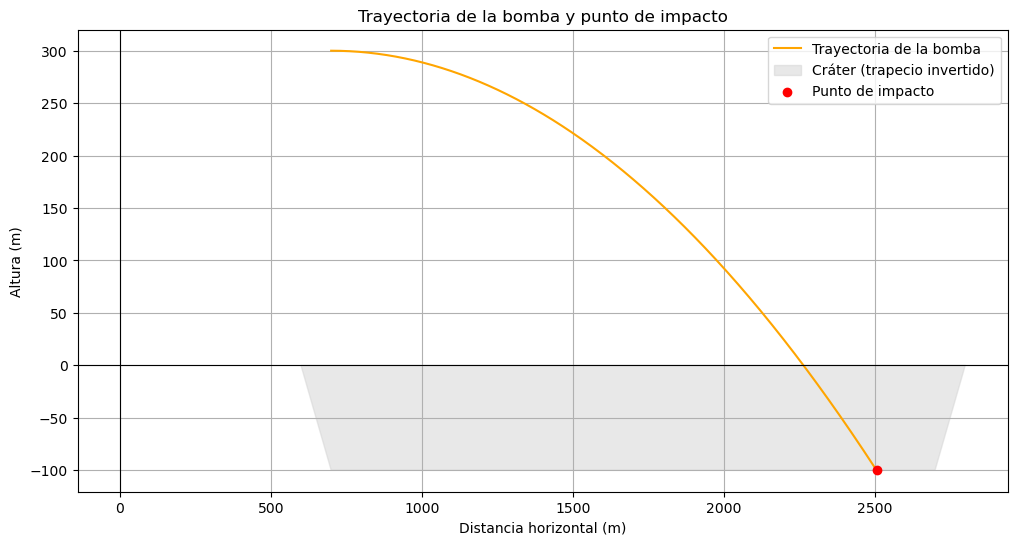

Punto de impacto: x = 2507.21 m, y = -100.00 m


In [11]:
import numpy as np
import matplotlib.pyplot as plt

#hola
ha = 300
hc = -100
L = 2000
alpha = np.radians(45)
d = 700
v0 = 200

v0x = v0
v0y = 0

g = 9.81
def trayectoria(x, x0, y0, v0x, v0y):
    t = (x - x0) / v0x
    return y0 + v0y * t - 0.5 * g * t**2

x_crater = [
    d,
    d + (hc / np.tan(alpha)),
    d + L - (hc / np.tan(alpha)),
    d + L
]
y_crater = [hc, 0, 0, hc]

x0 = d
y0 = ha
x_trayectoria = np.linspace(x0, x0 + L + 2 * d, 1000)
y_trayectoria = trayectoria(x_trayectoria, x0, y0, v0x, v0y)

impacto_x = None
for i in range(len(x_trayectoria)):
    if y_trayectoria[i] <= hc:
        impacto_x = x_trayectoria[i]
        impacto_y = hc
        break

if impacto_x and impacto_y:
    x_trayectoria_recortada = x_trayectoria[x_trayectoria <= impacto_x]
    y_trayectoria_recortada = y_trayectoria[:len(x_trayectoria_recortada)]
    
    plt.figure(figsize=(12, 6))
    plt.plot(x_trayectoria_recortada, y_trayectoria_recortada, label="Trayectoria de la bomba", color="orange")
    plt.fill(x_crater, y_crater, color="lightgrey", label="Cráter (trapecio invertido)", alpha=0.5)

    plt.scatter(impacto_x, impacto_y, color="red", label="Punto de impacto", zorder=5)

    plt.axhline(0, color="black", linewidth=0.8)
    plt.axvline(0, color="black", linewidth=0.8)
    plt.title("Trayectoria de la bomba y punto de impacto")
    plt.xlabel("Distancia horizontal (m)")
    plt.ylabel("Altura (m)")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Punto de impacto: x = {impacto_x:.2f} m, y = {impacto_y:.2f} m")
else:
    print("La bomba no impactó dentro del cráter.")


In [30]:

'''
# Solicitar al usuario los datos de entrada
ha = float(input("Ingrese la altura inicial (ha) en metros: "))
hc = float(input("Ingrese la altura del cráter (hc) en metros: "))
L = float(input("Ingrese la longitud de la zona del cráter (L) en metros: "))
alpha = np.radians(float(input("Ingrese el ángulo de lanzamiento en grados (alpha): ")))
d = float(input("Ingrese la distancia horizontal inicial (d) en metros: "))
v0 = float(input("Ingrese la velocidad inicial en m/s (v0): "))

'''



'\n# Solicitar al usuario los datos de entrada\nha = float(input("Ingrese la altura inicial (ha) en metros: "))\nhc = float(input("Ingrese la altura del cráter (hc) en metros: "))\nL = float(input("Ingrese la longitud de la zona del cráter (L) en metros: "))\nalpha = np.radians(float(input("Ingrese el ángulo de lanzamiento en grados (alpha): ")))\nd = float(input("Ingrese la distancia horizontal inicial (d) en metros: "))\nv0 = float(input("Ingrese la velocidad inicial en m/s (v0): "))\n\n'

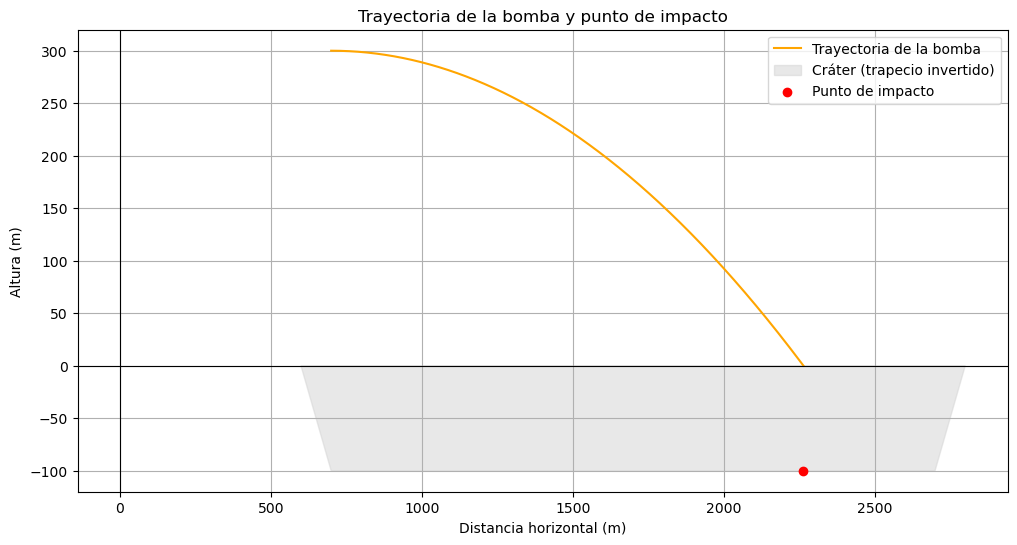

Punto de impacto: x = 2264.12 m, y = -100.00 m


In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de entrada
ha = 300  # Altura inicial (en metros)
hc = -100  # Altura del cráter (en metros)
L = 2000  # Longitud de la zona del cráter (en metros)
alpha = np.radians(45)  # Ángulo de lanzamiento (en radianes)
d = 700  # Distancia horizontal inicial (en metros)
v0 = 200  # Velocidad inicial de la bomba (en m/s)

# Aceleración debida a la gravedad (en m/s^2)
g = 9.81

# Función para calcular la trayectoria de la bomba (usando movimiento rectilíneo)
def trayectoria(x, x0, y0, v0x, v0y):
    t = (x - x0) / v0x  # Tiempo de vuelo hasta la posición x
    return y0 - 0.5 * g * t**2  # Altura en la posición x, solo gravedad afecta en y

# Función para graficar la trayectoria
def graficar_trayectoria():
    # Definir los puntos del cráter (forma de trapecio invertido)
    x_crater = [
        d,
        d + (hc / np.tan(alpha)),
        d + L - (hc / np.tan(alpha)),
        d + L
    ]
    y_crater = [hc, 0, 0, hc]

    # Posición inicial en X e Y
    x0 = d  # Posición inicial en X
    y0 = ha  # Altura inicial en Y

    # Componente de la velocidad horizontal (constante)
    v0x = v0  # La velocidad horizontal es constante (sin aceleración en X)
    v0y = 0  # No hay velocidad inicial en Y

    # Calcular el tiempo necesario para que la bomba caiga al suelo (y=0)
    tiempo_impacto = np.sqrt(2 * (ha) / g)  # Tiempo de caída al suelo desde la altura inicial
    impacto_x = x0 + v0x * tiempo_impacto  # Distancia horizontal en ese tiempo

    # Verificar si el impacto está dentro del rango del cráter
    if impacto_x >= d and impacto_x <= (d + L):  # Si cae dentro del cráter
        impacto_y = hc  # La bomba cae dentro del cráter, por lo tanto, la altura es hc
    else:
        impacto_y = 0  # Si no cae dentro del cráter, la bomba cae hasta el eje x (y=0)

    # Traza de la trayectoria (desde la posición inicial hasta el impacto)
    x_trayectoria = np.linspace(x0, impacto_x, 1000)  # Traza horizontal de la bomba
    y_trayectoria = trayectoria(x_trayectoria, x0, y0, v0x, v0y)  # Calcular las posiciones verticales

    # Graficar la trayectoria
    plt.figure(figsize=(12, 6))
    plt.plot(x_trayectoria, y_trayectoria, label="Trayectoria de la bomba", color="orange")
    plt.fill(x_crater, y_crater, color="lightgrey", label="Cráter (trapecio invertido)", alpha=0.5)

    # Mostrar el punto de impacto
    plt.scatter(impacto_x, impacto_y, color="red", label="Punto de impacto", zorder=5)

    # Configurar gráficos
    plt.axhline(0, color="black", linewidth=0.8)
    plt.axvline(0, color="black", linewidth=0.8)
    plt.title("Trayectoria de la bomba y punto de impacto")
    plt.xlabel("Distancia horizontal (m)")
    plt.ylabel("Altura (m)")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Punto de impacto: x = {impacto_x:.2f} m, y = {impacto_y:.2f} m")

# Llamar a la función para graficar la trayectoria
graficar_trayectoria()
